In [11]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [12]:
books_rating_df = pd.read_csv('Books_rating.csv', 
                              usecols=['Title', 'review/summary', 'review/score', 'review/text'],
                              nrows=1000)

In [13]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(review_text):
    sentiment_score = sia.polarity_scores(review_text)
    return sentiment_score['compound']  # Compound score as overall sentiment measure

books_rating_df['sentiment_score'] = books_rating_df['review/text'].fillna('').apply(analyze_sentiment)

# Group by Title and calculate the average sentiment score for each book
avg_sentiment_df = books_rating_df.groupby('Title')['sentiment_score'].mean().reset_index()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\swarn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
# Calculate Cosine Similarity Between Books
# We'll use TF-IDF to vectorize the sentiment scores for calculating similarity
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(avg_sentiment_df['sentiment_score'].astype(str))

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [15]:
#Recommend Books Based on Sentiment Similarity
def recommend_books_with_sentiment(title, df=avg_sentiment_df, top_n=5):
    idx = df[df['Title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    book_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[book_indices]

In [16]:
# Example
recommended_books = recommend_books_with_sentiment('Dr. Seuss: American Icon', top_n=5)
print(recommended_books)

0    A Dose of Sanity: Mind, Medicine, and Misdiagn...
1              A Walk in the Woods: a Play in Two Acts
2                                 A husband for Kutani
3                  Academic Freedom after September 11
4                                     Alaska Sourdough
Name: Title, dtype: object


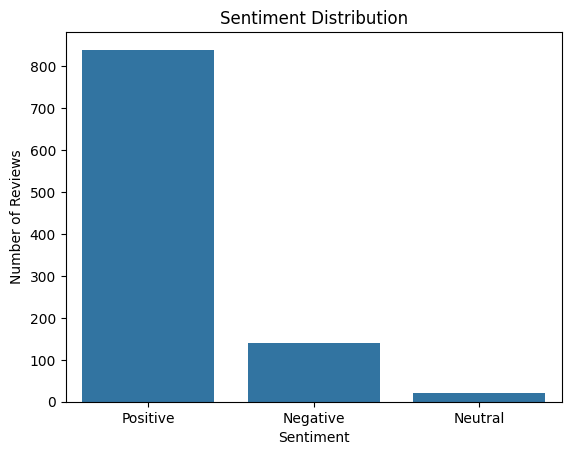

In [18]:
# Categorize sentiment
def sentiment_category(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

books_rating_df['sentiment_category'] = books_rating_df['sentiment_score'].apply(sentiment_category)

# Visualize the sentiment distribution
sns.countplot(x='sentiment_category', data=books_rating_df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


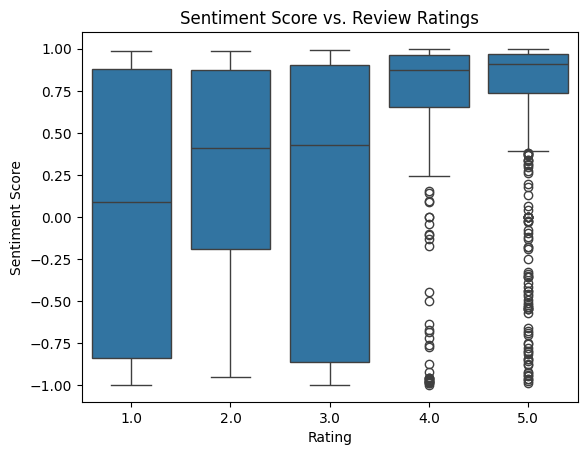

Correlation between Rating and Sentiment Score: 0.3483465527828195


In [19]:
sns.boxplot(x='review/score', y='sentiment_score', data=books_rating_df)
plt.title('Sentiment Score vs. Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.show()

# Pearson correlation coefficient
correlation = books_rating_df['review/score'].corr(books_rating_df['sentiment_score'])
print(f"Correlation between Rating and Sentiment Score: {correlation}")

In [22]:
from wordcloud import WordCloud

# Generate word clouds for positive and negative reviews
positive_reviews = books_rating_df[books_rating_df['sentiment_category'] == 'Positive']['review/text'].dropna().str.cat(sep=' ')
negative_reviews = books_rating_df[books_rating_df['sentiment_category'] == 'Negative']['review/text'].dropna().str.cat(sep=' ')

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

# Display the word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Negative Reviews')

plt.show()

ModuleNotFoundError: No module named 'wordcloud'